In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score
import optuna
from optuna.trial import Trial

In [2]:
# Data Loading
X_model = pd.read_csv('../data/X_model.csv')
Y_model = pd.read_csv('../data/Y_model.csv')

In [3]:
# Define preprocessors
def preprocess(X: pd.DataFrame):
    X = X.fillna(0)
    # Create new dataframe from columns "gender", "age_code", and "region_code"
    X_new = pd.DataFrame(X, columns=['gender', 'age_code', 'region_code'])
    GIT_range = r"202205[0-9]{2}"
    cGIT = np.sum(X.filter(regex=("c" + GIT_range), axis=1).values, axis=1)
    tGIT = np.sum(X.filter(regex=("t" + GIT_range), axis=1).values, axis=1)
    sGIT = np.sum(X.filter(regex=("s" + GIT_range), axis=1).values, axis=1)

    VAT_range = r"20220[17](?:[01][0-9]|2[0-5])"
    tVAT = np.sum(X.filter(regex=("t" + VAT_range), axis=1).values, axis=1)
    sVAT = np.sum(X.filter(regex=("s" + VAT_range), axis=1).values, axis=1)

    entire_range = r"2022[0-9]{4}"
    cEntire = np.sum(X.filter(regex=("c" + entire_range), axis=1).values, axis=1)
    tEntire = np.sum(X.filter(regex=("t" + entire_range), axis=1).values, axis=1)
    sEntire = np.sum(X.filter(regex=("s" + entire_range), axis=1).values, axis=1)

    rcGIT = np.divide(cGIT, cEntire)
    rtGIT = np.divide(tGIT, tEntire)
    rsGIT = np.divide(sGIT, sEntire)

    rtVAT = np.divide(tVAT, tEntire)
    rsVAT = np.divide(sVAT, sEntire)

    X_new['cGIT'] = cGIT
    X_new['tGIT'] = tGIT
    X_new['sGIT'] = sGIT

    X_new['tVAT'] = tVAT
    X_new['sVAT'] = sVAT

    X_new['cEntire'] = cEntire
    X_new['tEntire'] = tEntire
    X_new['sEntire'] = sEntire

    X_new['rcGIT'] = rcGIT
    X_new['rtGIT'] = rtGIT
    X_new['rsGIT'] = rsGIT

    X_new['rtVAT'] = rtVAT
    X_new['rsVAT'] = rsVAT

    X_new = X_new.fillna(0)
    print(X_new.head())

    return X_new

In [4]:
# Preprocess
X_model = preprocess(X_model)

/var/folders/xf/sy2fwpl54bzcxvmkf38nzntw0000gn/T/ipykernel_3196/3628091975.py:20: RuntimeWarning: invalid value encountered in true_divide
  rcGIT = np.divide(cGIT, cEntire)
/var/folders/xf/sy2fwpl54bzcxvmkf38nzntw0000gn/T/ipykernel_3196/3628091975.py:21: RuntimeWarning: invalid value encountered in true_divide
  rtGIT = np.divide(tGIT, tEntire)
/var/folders/xf/sy2fwpl54bzcxvmkf38nzntw0000gn/T/ipykernel_3196/3628091975.py:22: RuntimeWarning: invalid value encountered in true_divide
  rsGIT = np.divide(sGIT, sEntire)
/var/folders/xf/sy2fwpl54bzcxvmkf38nzntw0000gn/T/ipykernel_3196/3628091975.py:24: RuntimeWarning: invalid value encountered in true_divide
  rtVAT = np.divide(tVAT, tEntire)
/var/folders/xf/sy2fwpl54bzcxvmkf38nzntw0000gn/T/ipykernel_3196/3628091975.py:25: RuntimeWarning: invalid value encountered in true_divide
  rsVAT = np.divide(sVAT, sEntire)


   gender  age_code  region_code  cGIT  tGIT    sGIT  tVAT    sVAT  cEntire  \
0       1        13            7   0.0   0.0     0.0   0.0     0.0      1.0   
1       1         5            1   2.0   0.0    17.0   0.0   185.0     39.0   
2       2         6            2   6.0   3.0  2253.0   0.0  1712.0     26.0   
3       2         1            1   2.0   0.0   342.0   0.0     0.0      5.0   
4       2         5            1   2.0   0.0   273.0   0.0   104.0     10.0   

   tEntire  sEntire     rcGIT  rtGIT     rsGIT  rtVAT     rsVAT  
0      1.0     93.0  0.000000    0.0  0.000000    0.0  0.000000  
1      0.0    790.0  0.051282    0.0  0.021519    0.0  0.234177  
2      3.0   5119.0  0.230769    1.0  0.440125    0.0  0.334440  
3      0.0    647.0  0.400000    0.0  0.528594    0.0  0.000000  
4      1.0    608.0  0.200000    0.0  0.449013    0.0  0.171053  


In [5]:
# Task: Hyperparameter tuning with Optuna
def optimize(trial: Trial):
    # Construct a DecisionTreeClassifier object
    classifier = DecisionTreeClassifier(
        criterion="gini",
        splitter=trial.suggest_categorical('splitter', ['best', 'random']),
        max_depth=trial.suggest_int('max_depth', 1, 10),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 40),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
        min_weight_fraction_leaf=trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
        random_state=100,
        min_impurity_decrease=trial.suggest_float('min_impurity_decrease', 0.0, 0.5),
        class_weight="balanced", # Super imbalanced data
    )

    scores = cross_val_score(
        classifier, 
        X_model, 
        Y_model, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100),
        scoring='roc_auc' # for binary classification
    )

    return scores.mean()

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(optimize, show_progress_bar=True, n_trials=100)

# Print the best parameters
print(study.best_params)

/Users/hwanghyeongyu/miniforge3/envs/ai_learning/lib/python3.9/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

{'splitter': 'best', 'max_depth': 7, 'min_samples_split': 27, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.015129074321708548, 'min_impurity_decrease': 2.399403223116159e-05}


In [6]:
classifier = DecisionTreeClassifier(
    criterion="gini",
    splitter=study.best_params['splitter'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    min_weight_fraction_leaf=study.best_params['min_weight_fraction_leaf'],
    random_state=100,
    min_impurity_decrease=study.best_params['min_impurity_decrease'],
    class_weight="balanced", # Super imbalanced data
)

scores = cross_val_score(
    classifier, 
    X_model, 
    Y_model, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100),
    scoring='roc_auc'
)

print("Average ROC AUC Score", np.mean(scores))
print("Standard Deviation of ROC AUC Score", np.std(scores))

Average ROC AUC Score 0.8610744690217353
Standard Deviation of ROC AUC Score 0.0009063669767208892


[0.86088265 0.86277747 0.86097354 0.86065736 0.86008132]


<BarContainer object of 5 artists>

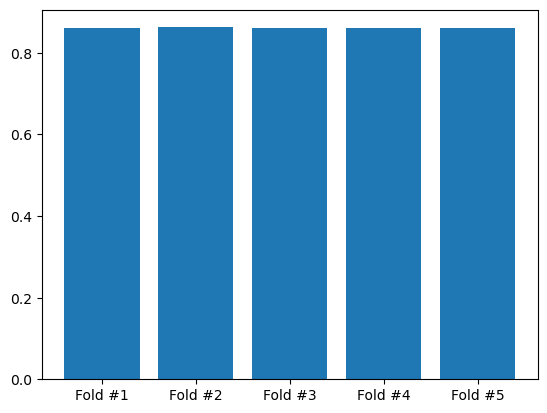

In [9]:
# Plot 5 scores in bar plot
print(scores)
plt.bar(list(map(lambda i: f"Fold #{i}", range(1, 6))), scores)